In [1]:
from ultralytics import YOLO
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
import torch
import numpy as np
import cv2
import PIL.Image as Image
import matplotlib.pyplot as plt
import os
from  detects import segany_mask_generate,yolo_mask_generate,vote_mask_generate,plot_sam_mask, pipeline
#sam = sam_model_registry["vit_h"](checkpoint="./segany/sam_vit_h_4b8939.pth")
sam = sam_model_registry["vit_l"](checkpoint="./segany/sam_vit_l_0b3195.pth").to("cuda")
#sam = sam_model_registry["vit_b"](checkpoint="./segany/sam_vit_b_01ec64.pth").to("cuda")

sam_model_generator = SamAutomaticMaskGenerator(sam,
                                                crop_n_layers=2,
                                                crop_n_points_downscale_factor=2)
yolo_model = YOLO('./yolo/ver3.pt')


d:\Anaconda\envs\CVproj\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
path = r"E:\stable-diffusion\save_image\temp\__jing_yuan_and_yanqing_honkai_and_1_more__ffb55c0bf62e078ecbc1034c50f2ee4e.png"
image = Image.open(path).convert("RGB")
yolo_masks, _= yolo_mask_generate(yolo_model,image)
sam_masks = segany_mask_generate(sam_model_generator,image)
voted_mask = vote_mask_generate(sam_masks,yolo_masks,threshold=0.3)


0: 384x640 1 person, 60.4ms
Speed: 4.7ms preprocess, 60.4ms inference, 16.0ms postprocess per image at shape (1, 3, 640, 640)


In [5]:
output_masks, output_images = pipeline(sam_model_generator, yolo_model, "D:/pyprojs/Anime-seg-yolov8/samples/sample.jpg", threshold=0.3)

0: 640x544 10 persons, 249.7ms
Speed: 3.0ms preprocess, 249.7ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


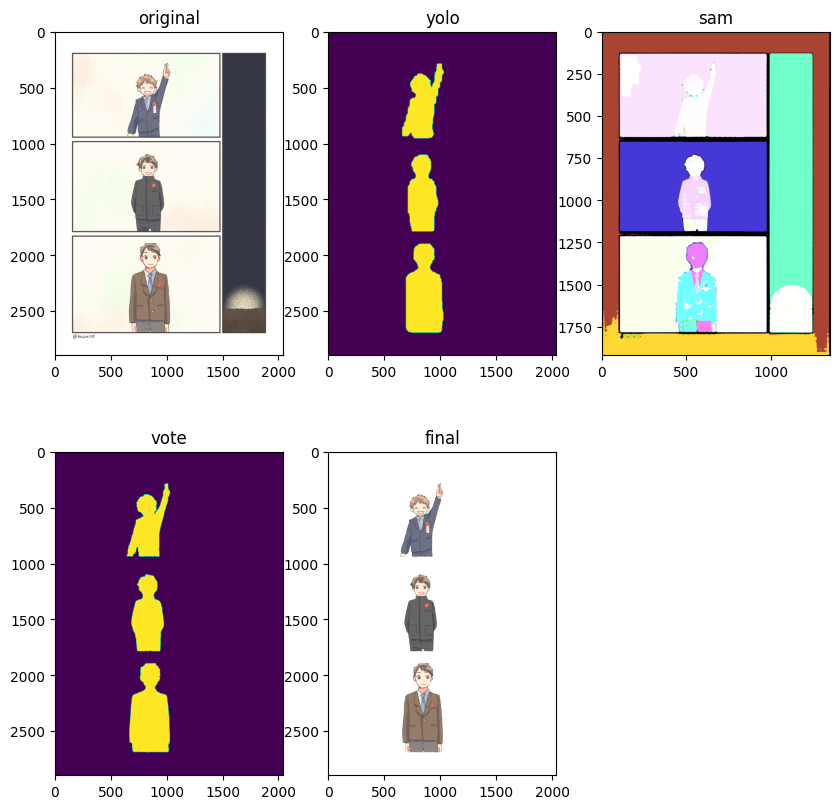

In [11]:
from PIL import Image
import os
from matplotlib import pyplot as plt
import numpy as np
pic_name = "__original_drawn_by_kojiro337__b860906d4416dfa67ce7f1186dfc881e.jpg"
seg_name = pic_name[:-4]+"_seg.png"
yolo_name = pic_name[:-4]+"_yolo.png"
vote_name = pic_name[:-4]+"_mask.png"
sam_name = pic_name[:-4]+"_sam.png"
pic = Image.open(os.path.join(r"D:\pyprojs\Anime-seg-yolov8\seg_output",pic_name))
seg = Image.open(os.path.join(r"D:\pyprojs\Anime-seg-yolov8\seg_output",seg_name))
yolo = Image.open(os.path.join(r"D:\pyprojs\Anime-seg-yolov8\seg_output",yolo_name))
vote = Image.open(os.path.join(r"D:\pyprojs\Anime-seg-yolov8\seg_output",vote_name))
sam = Image.open(os.path.join(r"D:\pyprojs\Anime-seg-yolov8\seg_output",sam_name))

#拼接出一张大图，(0,0)是原图，(0,1)是yolo，(1,0)是segany，(1,1)是vote
fig,ax = plt.subplots(2,3,figsize=(10,10))
ax[0,0].imshow(pic)
ax[0,0].set_title("original")
ax[0,1].imshow(yolo)
ax[0,1].set_title("yolo")
ax[0,2].imshow(sam)
ax[0,2].set_title("sam")
ax[1,0].imshow(vote)
ax[1,0].set_title("vote")
ax[1,1].imshow(seg)
ax[1,1].set_title("final")
plt.delaxes(ax[1,2])
plt.show()